#C2C



Final Aggregated Table across files:


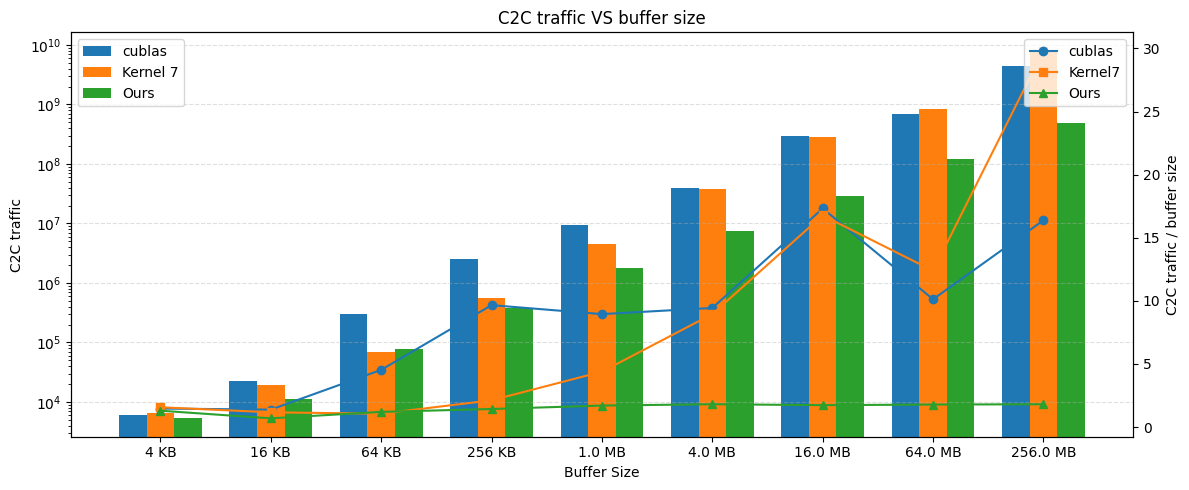

In [55]:
#!/usr/bin/env python3
import os
import re
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROFILE_DIR = "./output/profile"   # folder containing benchmark_{size}.csv files
FILE_GLOB   = os.path.join(PROFILE_DIR, "benchmark_*.csv")  # filename pattern

def parse_kernel_and_size_from_filename(path):
    # Expect filenames like: benchmark_{kernel}_{dim}.csv
    m = re.search(r"benchmark_(\w+)_(\d+)\.csv$", os.path.basename(path))
    return (m.group(1), int(m.group(2))) if m else None

def to_bytes(val, unit):
    """Convert Metric Value + Metric Unit into bytes."""
    if pd.isna(val):
        return 0
    try:
        v = float(val)
    except Exception:
        v = 0.0

    u = (unit or "").strip().lower()
    # normalize common variants
    if "gbyte" in u or u == "gb" or "gbytes" in u:
        return int(v * (1024**3))
    if "mbyte" in u or u == "mb" or "mbytes" in u:
        return int(v * (1024**2))
    if "kbyte" in u or u == "kb" or "kbytes" in u:
        return int(v * 1024)
    # treat anything else (including "byte", "bytes", "", unknown) as raw bytes
    return int(v)

def aggregate_file(path):
    """Return (size_in_bytes, group_df, avg_bytes) for a single CSV file."""
    kernel, size = parse_kernel_and_size_from_filename(path)
    df = pd.read_csv(path)

    # Filter Metric Name == "Received User Bytes"
    df = df[df["Metric Name"] == "Received User Bytes"].copy()
    if df.empty:
        group_df = pd.DataFrame(columns=["group_id", "Received User Bytes (bytes)"])
        return size, group_df, 0

    # Convert Metric Value + Unit => bytes
    df["Metric Bytes"] = [
        to_bytes(v, u) for v, u in zip(df["Metric Value"], df["Metric Unit"])
    ]

    num_rows = len(df)
    # if num_rows != 15:
    #     print(f"Warning: Expected 15 rows, but got {num_rows}")
    # assert(num_rows == 15)
    num_functions = max(1, num_rows // 15)   # <= your corrected rule

    group_size = num_functions               # aggregate every num_functions rows
    # group_size = 1

    # chunk sequentially by group_size
    grouped_rows = []
    gid = 0
    for start in range(0, num_rows, group_size):
        end = min(start + group_size, num_rows)
        group_sum = int(df["Metric Bytes"].iloc[start:end].sum())
        grouped_rows.append((gid, group_sum))
        gid += 1

    group_df = pd.DataFrame(grouped_rows, columns=["group_id", "Received User Bytes (bytes)"])
    avg_bytes = int(group_df["Received User Bytes (bytes)"].mean()) if not group_df.empty else 0
    return kernel, size, group_df, avg_bytes

paths = sorted(glob.glob(FILE_GLOB))
if not paths:
    print(f"No files matched {FILE_GLOB}")
else:

    final_rows = []
    for id, p in enumerate(paths):
        kernel, size, group_df, avg_bytes = aggregate_file(p)
        fname = os.path.basename(p)
        if group_df.empty:
            raise ValueError("  (no rows with Metric Name = 'Received User Bytes')")
            print("  (no rows with Metric Name = 'Received User Bytes')")


        # print(f"Average across groups for {fname}: {int(avg_bytes)} bytes")
        if size is not None:
            final_rows.append((kernel, size, int(avg_bytes)))

    if final_rows:
        final_df = pd.DataFrame(final_rows, columns=["Kernel", "Buffer Size", "C2C Traffic"]).sort_values("Buffer Size")
        print("\nFinal Aggregated Table across files:")
        # print(final_df.to_string(index=False))
    else:
        print("\nFinal Aggregated Table across files:\n  (no data)")


# print(final_df)
final_df = final_df[final_df["Buffer Size"] > 16]

cublas_kernel_df = final_df[final_df["Kernel"] == "0"].copy()
kernel7_df = final_df[final_df["Kernel"] == "7"].copy()
gh_kernel_df = final_df[final_df["Kernel"] == "8"].copy()

sizes = cublas_kernel_df["Buffer Size"].to_numpy()
sizes = sizes * sizes * 4
cublas_traffic = cublas_kernel_df["C2C Traffic"].to_numpy()
kernel7_traffic = kernel7_df["C2C Traffic"].to_numpy()
gh_traffic = gh_kernel_df["C2C Traffic"].to_numpy()

# print(f"cublas: {cublas_traffic}")
# print(f"kernel7: {kernel7_traffic}")
# print(f"gh: {gh_traffic}")
# print(f"size: {sizes}")



x = np.arange(len(sizes))
bar_w = 0.25

fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(x - bar_w, cublas_traffic, width=bar_w, label='cublas')
ax.bar(x , kernel7_traffic, width=bar_w, label='Kernel 7')
ax.bar(x + bar_w, gh_traffic, width=bar_w, label='Ours')

# X tick labels: KB if < 1MB, else MB
def fmt_size(b):
    # b = b*b*4
    if b < 1024 * 1024:
        return f"{b/1024:.0f} KB"
    else:
        return f"{b/(1024*1024):.1f} MB"

ax.set_xticks(x, [fmt_size(s) for s in sizes], rotation=0)

ax.set_ylabel('C2C traffic')
ax.set_xlabel('Buffer Size')
ax.set_title('C2C traffic VS buffer size')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_yscale("log")


# Secondary axis for ratios
ax2 = ax.twinx()
ratio_cublas = cublas_traffic / sizes
ratio_kernel7 = kernel7_traffic / sizes
ratio_gh = gh_traffic / sizes

ax2.plot(x, ratio_cublas, marker='o', color='tab:blue', label='cublas')
ax2.plot(x, ratio_kernel7, marker='s', color='tab:orange', label='Kernel7')
ax2.plot(x, ratio_gh, marker='^', color='tab:green', label='Ours')
ax2.set_ylabel('C2C traffic / buffer size')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()